# Opening Data and Trialing Models

This notebook contains my first run through of this data challenge. It wasnt written at the time with the idea that it would be read by anyone else, so it is not nearly as verbosely commented as Final_Submission.ipynb.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error as rmsler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
Holidays = pd.read_csv('Data/holidays_events.csv', 
                       parse_dates=['date'], 
                       index_col=['date'])
Oil_prices = pd.read_csv('Data/oil.csv', 
                       parse_dates=['date'], 
                       index_col=['date'])
Stores = pd.read_csv('Data/stores.csv')
Test = pd.read_csv('Data/test.csv',
                       parse_dates=['date'],  
                       index_col=['id'])
Train = pd.read_csv('Data/train.csv',
                       parse_dates=['date'],  
                       index_col=['id'])
Transactions = pd.read_csv('Data/transactions.csv',
                       parse_dates=['date'], 
                       index_col=['date'])   

## Building familiarity with the data set

In [3]:
dates_training = list(Train['date'])
dates_test = list(Test['date'])

start_tr, end_tr = dates_training[0].date(), dates_training[-1].date()
start_ts, end_ts = dates_test[0].date(), dates_test[-1].date()

print(f'Training starts at {start_tr}, and ends on {end_tr}.')
print(f'Testing starts at {start_ts}, and ends on {end_ts}.')

Training starts at 2013-01-01, and ends on 2017-08-15.
Testing starts at 2017-08-16, and ends on 2017-08-31.


The goal here is to forecast sales across many different stores and for many different food groups. There are 54 unique stores across many regions, and 33 subgroups of food types.

In [81]:
Test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


## Validation split

As this is a 2 week forecasting task, a way of sorting out the validation is by separating out the last 2 weeks of data, and using this as the validation set. We select the second so that the validaion set starts the day after the payday, like the testing set.

In [23]:
training_start = "2016-01-01"
validation_start = "2017-08-02"
validation_end   = "2017-08-15"

## Basic Feature Engineering 

We are given a hint that in Ecuador they are paid on the 1st and the 15th of every month. We are also told that econmic productivity depends a lot on oil prices. 
Lets add in a pay day flag, and an oil prices flag.

In [5]:
All_data = pd.concat([Train], ignore_index=True)


In [6]:
last_day_of_month_tr = All_data['date'] + pd.offsets.MonthEnd(0)

# Create 'payday' column with 1 if day is 1, 15, or last day of the month, else 0
All_data.loc[:, 'payday'] = np.where(All_data['date'].dt.day.isin([1, 15]) | (All_data['date'] == last_day_of_month_tr), 1, 0)


We also have oil prices, so lets add those in as a feature. Note these have been forward filled to deal with missing values (and a single backfill to fill element at 0).

In [7]:
All_data = All_data.merge(Oil_prices, on='date', how='left')
All_data.dcoilwtico = All_data.dcoilwtico.ffill().bfill()

Next, we add in a simple set of date based features. These will be year, month, day of week. 

In [8]:
# Feature engineering
def day_feature_engineering(df):
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

## Adding national holidays

Perhaps you could be more accurate if you were to consider all of the stores which are affected by any given holiday, and including these as flags i.e. 'affected by holiday' column. I do not opt to do this. This allows for omission of the entire store dataset. A possible extension would be to add these back in. 


In [9]:
national_hols = Holidays.loc[(Holidays['locale'] == 'National') & (~Holidays['transferred'])]

# Create a column indicating national holidays in Train
All_data['is_holiday'] = All_data.index.isin(national_hols.index).astype(int)


## Mean Feature inclusion

Now we add in some features which are statistical averages over prior performace of a particular product type on a given day of the week

In [10]:
# we make a new df which has all of the mean sales in for each product, and stitch these together 
mean_sales = All_data.groupby(['store_nbr', 'family']).sales.mean().reset_index()
All_data = pd.merge(All_data, mean_sales, on=['store_nbr', 'family'], suffixes=('', '_mean'), how='left')

In [11]:
All_data.dcoilwtico.isna().sum()

0

## Relational Feature Inclusion

The final set of features we add in are lag features. We want a 7 day, 15 day and 28 day lag feature. 

In [12]:
Training   = All_data.loc[All_data['date'] < validation_start]
Validation = All_data.loc[(All_data['date'] >= validation_start) & (All_data['date'] <= validation_end)]

In [13]:
Validation

,date,store_nbr,family,sales,onpromotion,payday,dcoilwtico,is_holiday,sales_mean
2975940,2017-08-02,1,AUTOMOTIVE,4.000,0,0,49.60,0,3.251188
2975941,2017-08-02,1,BABY CARE,0.000,0,0,49.60,0,0.000000
2975942,2017-08-02,1,BEAUTY,2.000,1,0,49.60,0,2.408551
2975943,2017-08-02,1,BEVERAGES,2645.000,25,0,49.60,0,1587.748812
2975944,2017-08-02,1,BOOKS,0.000,0,0,49.60,0,0.125297
...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,1,47.57,0,483.880389
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1,47.57,0,88.762428
3000885,2017-08-15,9,PRODUCE,2419.729,148,1,47.57,0,969.134497
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,1,47.57,0,6.051069


In [14]:
# We now artificially remove all of the sales data from the validation set, so that it has to get values from lag column 
val_s = Validation.copy()
val_s.sales = np.nan
train_and_val = pd.concat([Training, val_s], ignore_index=True)

In [15]:
# Here we add lag features 
def add_lag_features(df, lags):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df['sales'].shift(lag)
        # Fill missing values in the lagged columns with values from the corresponding lag column
        # It is inelegant, but we have to do this twice to fill the full region of consideration 
        df[f'lag_{lag}'] = df[f'lag_{lag}'].fillna(df[f'lag_{lag}'].shift(lag))
        df[f'lag_{lag}'] = df[f'lag_{lag}'].fillna(df[f'lag_{lag}'].shift(lag))
    return df

In [16]:
group_dfs = []
lags = [7, 14, 28]
sorted_df = train_and_val.sort_values(by = ['store_nbr', 'family'])
for (store_nbr, family), group_df in sorted_df.groupby(['store_nbr', 'family']):
    # Apply lag features to the group
    group_df_with_lags = add_lag_features(group_df, lags)
    
    # Append the modified group DataFrame to the list
    group_dfs.append(group_df_with_lags)

# Concatenate all group DataFrames back into one DataFrame
processed_df = pd.concat(group_dfs)

# Now processed_df contains the original DataFrame with lag features added group by group
pd.DataFrame(processed_df).tail(30);

In [17]:
processed_df

,date,store_nbr,family,sales,onpromotion,payday,dcoilwtico,is_holiday,sales_mean,lag_7,lag_14,lag_28
0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,93.14,0,3.251188,NaN,NaN,NaN
1782,2013-01-02,1,AUTOMOTIVE,2.0,0,0,93.14,0,3.251188,NaN,NaN,NaN
3564,2013-01-03,1,AUTOMOTIVE,3.0,0,0,92.97,0,3.251188,NaN,NaN,NaN
5346,2013-01-04,1,AUTOMOTIVE,3.0,0,0,93.12,0,3.251188,NaN,NaN,NaN
7128,2013-01-05,1,AUTOMOTIVE,5.0,0,0,93.12,0,3.251188,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2993627,2017-08-11,54,SEAFOOD,NaN,0,0,48.81,0,1.744656,4.0,4.0,0.0
2995409,2017-08-12,54,SEAFOOD,NaN,1,0,48.81,0,1.744656,4.0,4.0,2.0
2997191,2017-08-13,54,SEAFOOD,NaN,0,0,48.81,0,1.744656,4.0,4.0,5.0
2998973,2017-08-14,54,SEAFOOD,NaN,0,0,47.59,0,1.744656,4.0,4.0,3.0


In [18]:
def target_encode_family_to_integer(df):
    # Assuming df is your DataFrame containing the data
    
    # Create a sorted list of unique families
    unique_families = sorted(df['family'].unique())
    
    # Create a dictionary to map each family to a unique integer
    family_to_integer = {family: idx for idx, family in enumerate(unique_families)}
    
    # Apply the encoding to the 'family' column
    df['family'] = df['family'].map(family_to_integer)
    
    return df

# Example usage:
# Assuming df is your DataFrame containing the data with 'family' column
df_encoded = target_encode_family_to_integer(processed_df)

In [21]:
df_encoded = day_feature_engineering(df_encoded)
df_encoded

,date,store_nbr,family,sales,onpromotion,payday,dcoilwtico,is_holiday,sales_mean,lag_7,lag_14,lag_28,day,month,year,dayofweek
0,2013-01-01,1,0,0.0,0,1,93.14,0,3.251188,NaN,NaN,NaN,1,1,2013,1
1782,2013-01-02,1,0,2.0,0,0,93.14,0,3.251188,NaN,NaN,NaN,2,1,2013,2
3564,2013-01-03,1,0,3.0,0,0,92.97,0,3.251188,NaN,NaN,NaN,3,1,2013,3
5346,2013-01-04,1,0,3.0,0,0,93.12,0,3.251188,NaN,NaN,NaN,4,1,2013,4
7128,2013-01-05,1,0,5.0,0,0,93.12,0,3.251188,NaN,NaN,NaN,5,1,2013,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993627,2017-08-11,54,32,NaN,0,0,48.81,0,1.744656,4.0,4.0,0.0,11,8,2017,4
2995409,2017-08-12,54,32,NaN,1,0,48.81,0,1.744656,4.0,4.0,2.0,12,8,2017,5
2997191,2017-08-13,54,32,NaN,0,0,48.81,0,1.744656,4.0,4.0,5.0,13,8,2017,6
2998973,2017-08-14,54,32,NaN,0,0,47.59,0,1.744656,4.0,4.0,3.0,14,8,2017,0


In [22]:
# Now, we re add in the sales column now that the lags have been calculated blindly 

In [24]:
df_encoded['sales'] = All_data['sales']
# train_data = df_encoded.loc[(df_encoded['date'] < validation_start) & ~(())]
# valid_data  = df_encoded.loc[(df_encoded['date'] >= validation_start) & (df_encoded['date'] <= validation_end)]
# test_data = df_encoded.loc[df_encoded['date'] > validation_end]

In [25]:
train_data_w_quake = df_encoded.loc[(df_encoded['date'] > training_start) & (df_encoded['date'] < validation_start)]
train_data = train_data_w_quake.loc[~((train_data_w_quake['date'] >= "2016-04-16") & (train_data_w_quake['date'] <= "2016-05-16"))]
val_data = df_encoded.loc[df_encoded['date'] >= validation_start]

## Model Training

we now make use of light gmb to forecast the trends in this data set

In [36]:
# df_encoded['sales'] = All_data['sales']
# train_data = df_encoded.loc[df_encoded['date'] < validation_start]
# valid_data  = df_encoded.loc[(df_encoded['date'] >= validation_start) & (df_encoded['date'] <= validation_end)]
# test_data = df_encoded.loc[df_encoded['date'] > validation_end]

In [26]:
features = ['store_nbr', 'family', 'onpromotion', 'payday', 'dcoilwtico', 'day', 'month', 'year', 'dayofweek', 'is_holiday', 
            'sales_mean', 'lag_7', 'lag_14', 'lag_28']
target = 'sales'

X_train = train_data[features]
y_train = train_data[target]
X_valid = val_data[features]
y_valid = val_data[target]

### Grid Search 

In [28]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [30]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 50, 100],
    'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'lambda_l1': [0.0, 0.1, 0.5, 1.0],
    'lambda_l2': [0.0, 0.1, 0.5, 1.0],
    'min_child_samples': [10, 20, 30, 50],
    'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
    'bagging_freq': [1, 5, 10]
}

In [31]:
model = lgb.LGBMRegressor(objective='tweedie', metric='rmse', boosting_type='gbdt', verbose=1)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmse_scorer, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 5 folds for each of 76800 candidates, totalling 384000 fits


KeyboardInterrupt: 

### Non grid search method 

In [38]:
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_valid, label=y_valid)

params = {
    'objective': 'tweedie',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_child_samples': 20,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 2
}

In [40]:
model = lgb.train(params,
                  train_dataset,
                  num_boost_round=1000,
                  valid_sets=[train_dataset, valid_dataset])

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.848225
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.218012
[LightGBM] [Debug] init for col-wise cost 0.050904 seconds, init for row-wise cost 0.119739 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1626
[LightGBM] [Info] Number of data points in the train set: 2975940, number of used features: 13
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score 5.877538
[LightGBM] [Debug] Re-bagging, using 2381659 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and dept

In [43]:
y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)

In [45]:
y_train_clipped = np.clip(y_train_pred, 0, None)
rmsle1 = rmsler(y_train, y_train_clipped)
y_pred_clipped = np.clip(y_valid_pred, 0, None)

rmsle2 = rmsler(y_valid, y_pred_clipped)
print(f'Validation RMSLE: {rmsle2}')
print(f'Train RMSLE: {rmsle1}')

Validation RMSLE: 0.18950438671392358
Train RMSLE: 0.2046317990224517


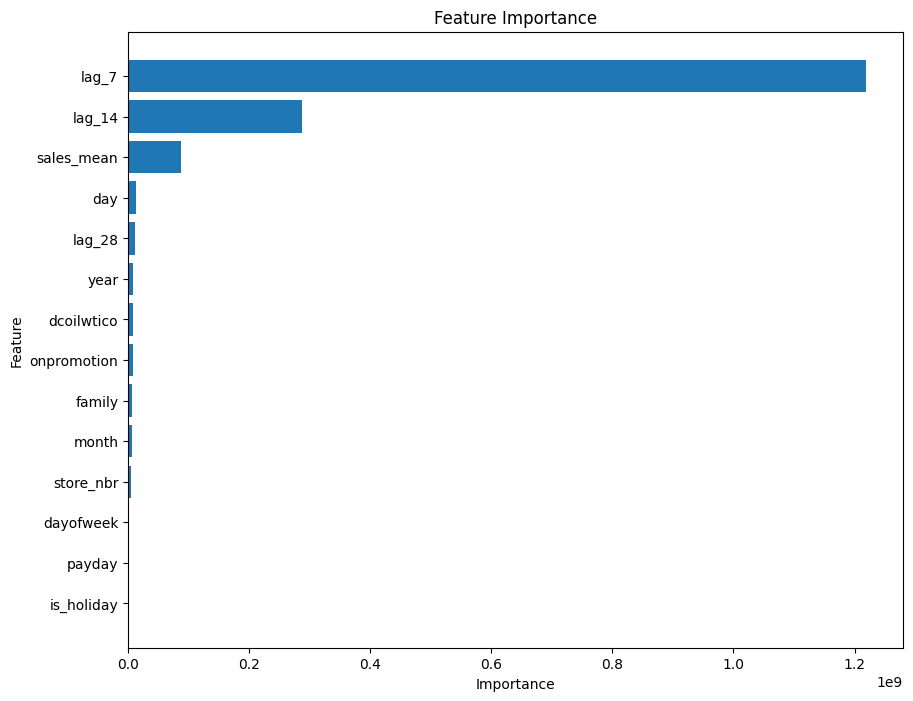

In [46]:
importance = model.feature_importance(importance_type='gain')  # or 'gain'
feature_names = model.feature_name()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Training Log

#### 1

In [ ]:
# params = {
#     'objective': 'regression', 
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.05,
#     'num_leaves': 31,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 2
# }

# model = lgb.train(params,
#                   train_dataset,
#                   num_boost_round=1000,
#                   valid_sets=[train_dataset, valid_dataset])

# resulted in Validation RMSLE: 12.657290009315009
# this high rmsle was dut to an incorrect index alignment between the two datasets being input into the rmsle checker 


#### 2

In [ ]:
# params = {
#     'objective': 'tweedie', # regression used before
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.05,
#     'num_leaves': 31,
#     'feature_fraction': 0.9,
#     'lambda_l1': 0.1,
#     'lambda_l2': 0.1,
#     'min_child_samples': 20,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 2
# } 
# model = lgb.train(params,
#                   train_dataset,
#                   num_boost_round=1000,
#                   valid_sets=[train_dataset, valid_dataset])
# resulted in Validation RMSLE: 0.1895043835463883

## Submissions

In [47]:
group_dfs = []
lags = [7, 14, 28]
sorted_df_all = All_data.sort_values(by = ['store_nbr', 'family'])
for (store_nbr, family), group_df in sorted_df_all.groupby(['store_nbr', 'family']):
    # Apply lag features to the group
    group_df_with_lags = add_lag_features(group_df, lags)
    
    # Append the modified group DataFrame to the list
    group_dfs.append(group_df_with_lags)

# Concatenate all group DataFrames back into one DataFrame
processed_df_all = pd.concat(group_dfs)
pd.DataFrame(processed_df_all);

In [48]:
test_data = processed_df_all.loc[processed_df_all['date'] > validation_end]
test_data = target_encode_family_to_integer(test_data)

C:\Users\harry\AppData\Local\Temp\ipykernel_21840\4227364947.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['family'] = df['family'].map(family_to_integer)


In [77]:
X_test = test_data[features]
y_test = test_data[target]

y_test_pred = pd.DataFrame(model.predict(X_test, num_iteration=model.best_iteration), columns=['sales'], index=y_test.index)

#y_test_df = pd.DataFrame(y_test_pred.values, columns=['sales'], index=y_test.index)
y_test_pred = y_test_pred.rename_axis('id')
y_test_pred.to_csv('Submission1.csv')